Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-mhpdqmwi
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-mhpdqmwi
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


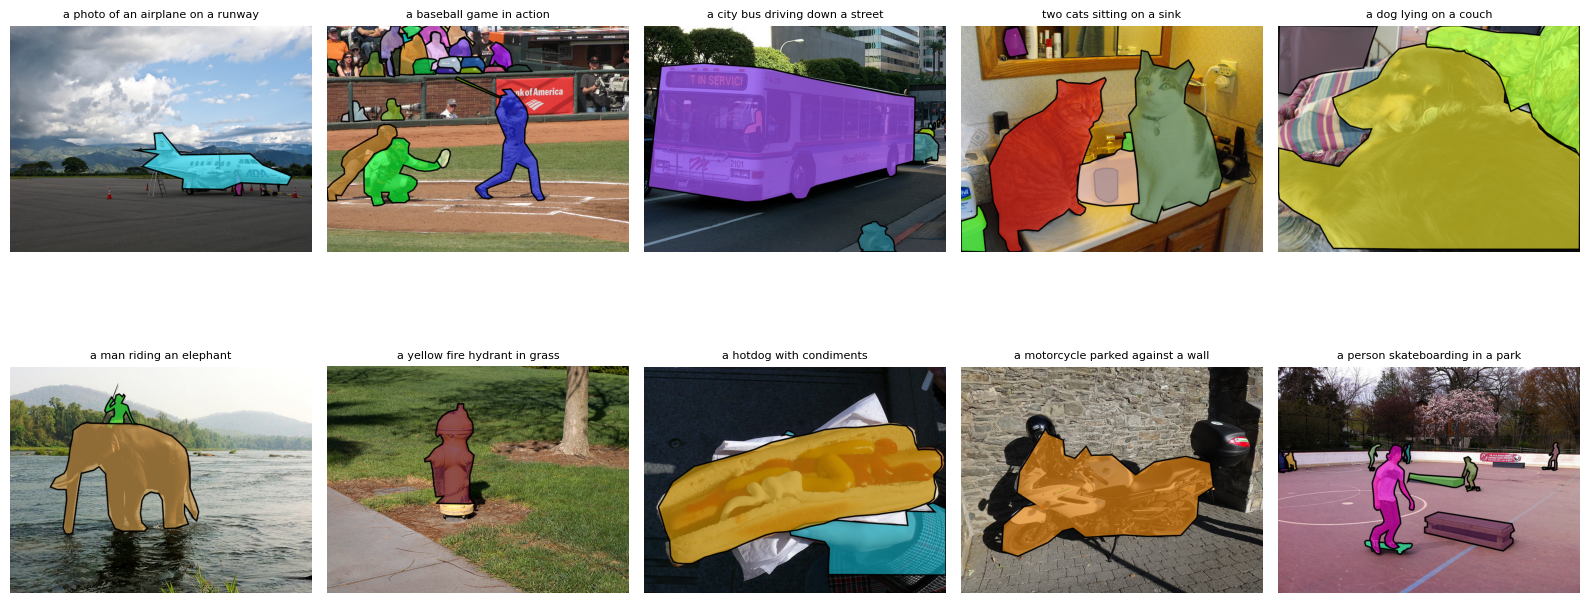

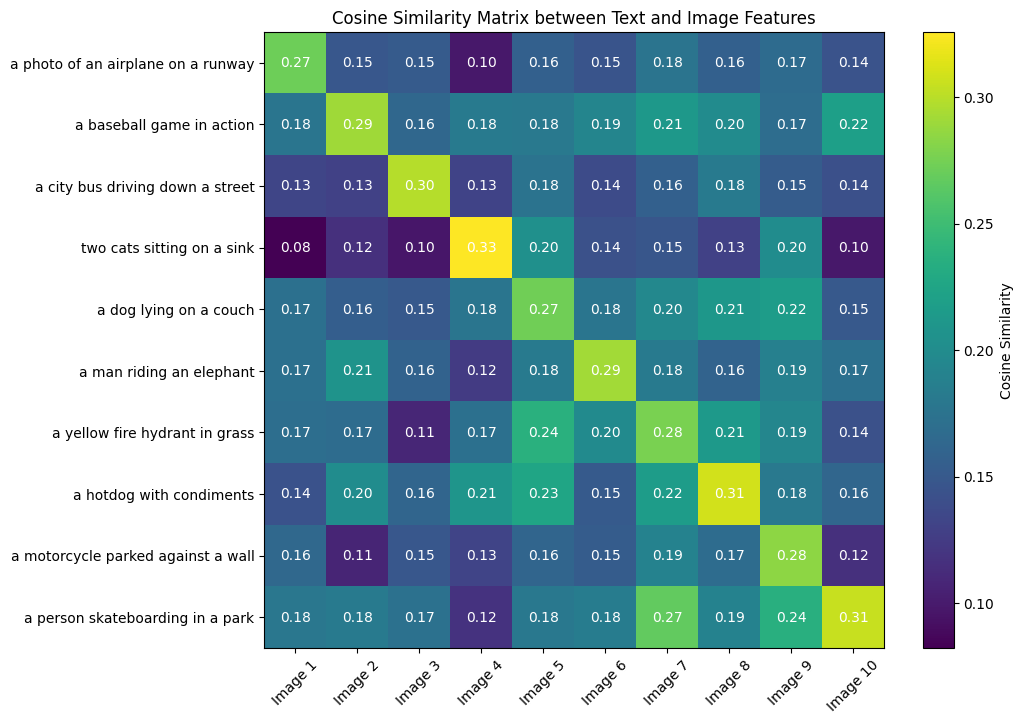

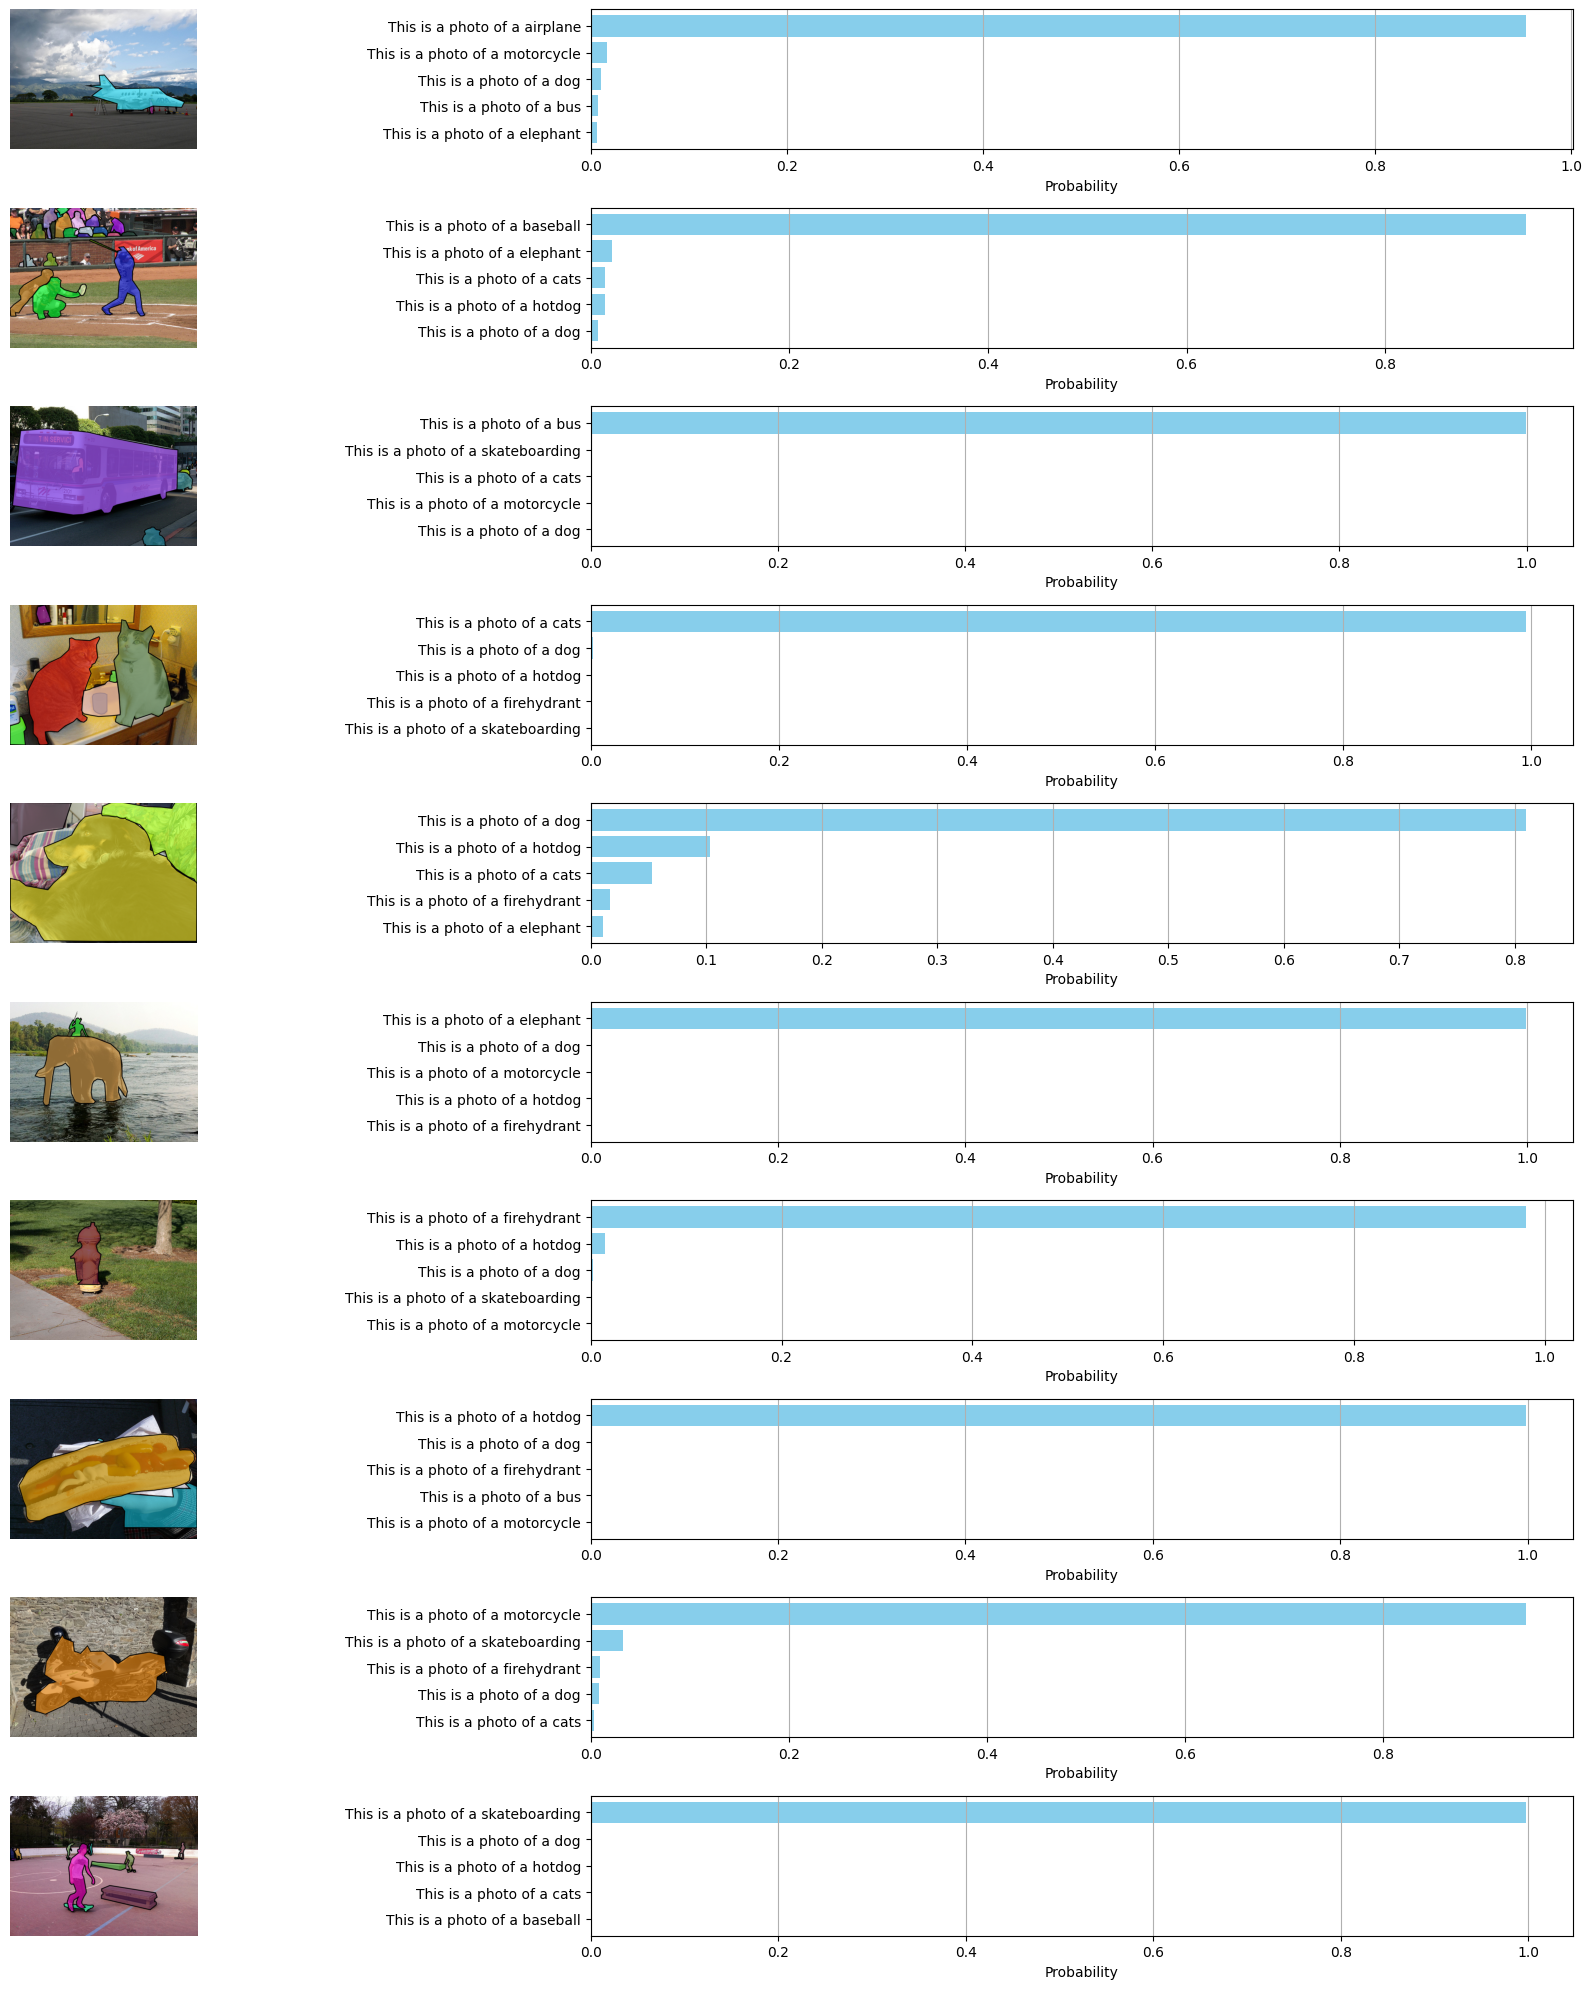

In [4]:
# Mount Google Drive and Import Necessary Libraries
from google.colab import drive
drive.mount('/content/drive')

! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

import os
import numpy as np
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt

# Change directory to your project folder
os.chdir('/content/drive/MyDrive/Colab Notebooks/Artificial Intelligence/Project2/')

# Load CLIP model and set it to evaluation mode
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

# Define the image descriptions dictionary
descriptions = {
    "airplane": "a photo of an airplane on a runway",
    "skateboarding": "a person skateboarding in a park",
    "bus": "a city bus driving down a street",
    "hotdog": "a hotdog with condiments",
    "baseball": "a baseball game in action",
    "cats": "two cats sitting on a sink",
    "elephant": "a man riding an elephant",
    "firehydrant": "a yellow fire hydrant in grass",
    "dog": "a dog lying on a couch",
    "motorcycle": "a motorcycle parked against a wall"
}

# Load images from the "image10" folder and prepare for processing
original_images = []
images = []
texts = []
image_folder_path = 'image10'

# Set up a grid to display images with captions
plt.figure(figsize=(16, 8))
for i, filename in enumerate(sorted(os.listdir(image_folder_path))):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        name = os.path.splitext(filename)[0]
        if name in descriptions:
            image_path = os.path.join(image_folder_path, filename)
            image = Image.open(image_path).convert("RGB")
            original_images.append(image)
            images.append(preprocess(image))
            texts.append(descriptions[name])

            # Display each image in a 2x5 grid with caption
            plt.subplot(2, 5, i + 1)
            plt.imshow(image)
            plt.axis("off")
            plt.title(descriptions[name], fontsize=8, wrap=True)  # Caption below each image

plt.tight_layout()
plt.show()

# Prepare images and texts for CLIP model processing
image_input = torch.tensor(np.stack(images)).to(device)
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).to(device)

# Process images and text features with CLIP
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

# Normalize features for cosine similarity
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# Calculate cosine similarity matrix and display as heatmap
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
count = len(descriptions)

plt.figure(figsize=(10, 8))
plt.imshow(similarity, cmap="viridis", aspect='auto')
plt.colorbar(label="Cosine Similarity")
plt.yticks(range(count), texts, fontsize=10)
plt.xticks(range(count), [f"Image {i+1}" for i in range(count)], fontsize=10, rotation=45)

# Add similarity values inside the heatmap for clarity
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", color="white")

plt.title("Cosine Similarity Matrix between Text and Image Features")
plt.show()

# Image classification using CLIP on descriptions
text_descriptions = [f"This is a photo of a {label}" for label in descriptions.keys()]
text_tokens = clip.tokenize(text_descriptions).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Calculate probabilities of each class for each image
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

# Plot image classifications with top predictions (adjusted subplot configuration)
plt.figure(figsize=(20, 20))  # Adjusted figure size for better spacing

for i, image in enumerate(original_images):
    # Display each image on the left
    plt.subplot(10, 2, i * 2 + 1)
    plt.imshow(image)
    plt.axis("off")

    # Display the top predictions with probability bars on the right
    plt.subplot(10, 2, i * 2 + 2)
    y = np.arange(top_probs.shape[-1])
    plt.barh(y, top_probs[i].numpy(), color="skyblue")
    plt.gca().invert_yaxis()
    plt.yticks(y, [text_descriptions[index] for index in top_labels[i].numpy()])
    plt.xlabel("Probability")
    plt.grid(axis='x')

plt.tight_layout()
plt.show()
